In [51]:
# %matplotlib widget

import numpy as np
import math
from matplotlib import pyplot as plt
import torch
import tifffile
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from findpeaks import findpeaks
# from pathlib import Path
import glob
from model import BraggNN
from matplotlib.animation import FuncAnimation
import h5py

# BraggNN demonstration on simulated Bragg peak

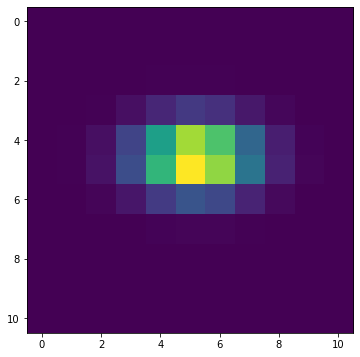

In [52]:
# load a pre-trained model that takes 11x11 patch as input
model  = BraggNN(imgsz=11, fcsz=(16, 8, 4, 2)) # should use the same argu as it in the training.
mdl_fn = 'models/fc16_8_4_2-sz11.pth'
model.load_state_dict(torch.load(mdl_fn, map_location=torch.device('cpu')))

#Generate 11x11 patch containing a Bragg peak and noise, with 100 SNR
X_test = np.zeros((11, 11)) + np.random.random((11,11))
x_cen, y_cen = 5.2, 4.6
sig_x, sig_y = 0.6, 1.5
for x in range(11):
    for y in range(11):
        X_test[y][x] = 100*(np.exp(-(x-x_cen)*(x-x_cen)/2*sig_x -(y-y_cen)*(y-y_cen)/2*sig_y))


# the input needs to be normalized to 0-1, e.g., rescale using min-max norm
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

plt.figure(figsize = (6,6))
plt.imshow(X_test)

(1, 1, 11, 11)
Peak was generated at (5.20, 4.60)
NN Peak location fit is (5.14, 4.57)
Fit error is 0.062 pixels


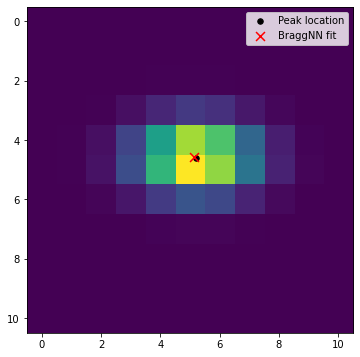

In [68]:
#Feed simulated patch to pre-trained CNN
print(X_test[np.newaxis, np.newaxis].shape)
input_tensor = torch.from_numpy(X_test[np.newaxis, np.newaxis].astype('float32'))
with torch.no_grad():
    pred = model.forward(input_tensor).cpu().numpy()
fit = pred * 11
print('Peak was generated at (%.2f, %.2f)' %(x_cen, y_cen))
print('NN Peak location fit is (%.2f, %.2f)' %(fit[0][0], fit[0][1]))
print('Fit error is %.3f pixels' %np.sqrt((x_cen-fit[0][0])**2 + (y_cen - fit[0][1])**2))

plt.figure(figsize = (6,6))
plt.imshow(X_test)
plt.scatter(x_cen, y_cen, color = 'k', s=30, label = 'Peak location')
plt.scatter(fit[0,0], fit[0,1], color='r', s=80, marker = 'x', label = 'BraggNN fit')
plt.legend()

# Code test on single detector image from our data
### Load and pre-process data

Text(0.5, 1.0, 'Binned and masked data')

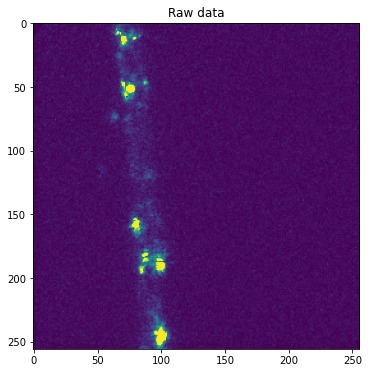

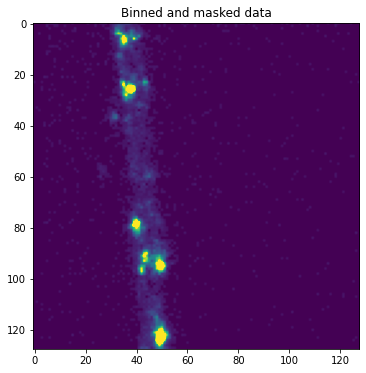

In [82]:
#Load and plot example detector image

image = tifffile.imread('../../data//CoinCell_120um_0.33C_good/p3/Shpyrko223a_S5143_00000.tif')
plt.figure(figsize = (6,6))
plt.title('Raw data')
plt.imshow(image, vmax = 100)

#Method to re-bin detector image to a new shape
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

#Rebin and mask image
minval = 5
newshape = (128,128)
binned_image = rebin(image, newshape)
binned_image[binned_image<minval] = 0

plt.figure(figsize = (6,6))
plt.imshow(binned_image, vmax = 100)
plt.title('Binned and masked data')

### Use findpeaks() to estimate peak locations

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


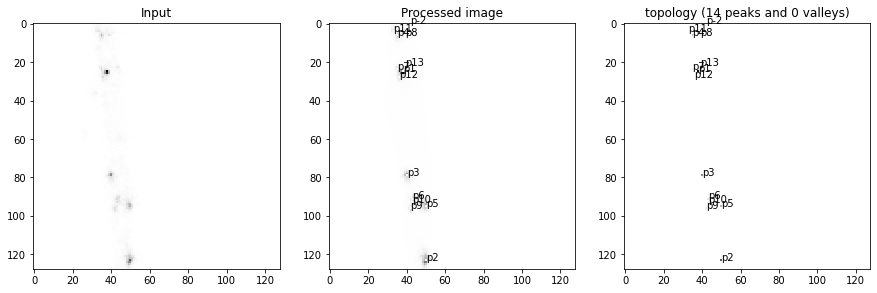

Located 9 peaks after filtering


In [83]:
def findPeaks(binned_image, minval = 5, minscore = 10):
    '''Function that uses findpeaks module to roughly locate peaks in detector image
    
    Arguments:
    binned_image - 2D array w/ detector image
    minval - minimum value below which background is set to 0 (default 5)
    minscore - minimum peak persistence score to be included in results
    
    Returns:
    x, y - arrays of coordinates for peaks (Npeaks,2), dtype = int
    scores - array of persistence scores for each peak (Npeaks), dtype = int
    '''

    # Initialize
    fp = findpeaks(method='topology',verbose = 3)
    #Mask off any values < minval
    mask = binned_image > minval
    X = binned_image * mask
    # Fit topology method on the image
    results = fp.fit(X)
    fp.plot()
    #Select only peaks from result, with score > minscore
    peak_mask = (results['persistence']['peak'].values) & (results['persistence']['score'].values > minscore)
    scores = results['persistence']['score'][peak_mask]
    x = results['persistence']['x'][peak_mask]
    y = results['persistence']['y'][peak_mask]
    print('Located %i peaks after filtering' %len(scores))
    return x, y, scores

x, y, scores = findPeaks(binned_image)

### Overlay filtered rough peak locations from findpeaks() on input data

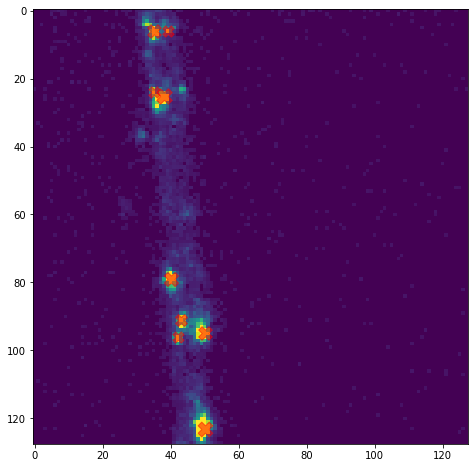

In [84]:
plt.figure(figsize = (8,8))
plt.imshow(binned_image, vmax = 100)
for i in range(len(scores)):
    plt.scatter(x[i], y[i], color = 'red', marker = 'X', s = np.log10(scores[i]) * 100, alpha = 0.5)


Unable to generate/fit patch
[[37.88563299 25.38623762]
 [39.89793301 78.61728334]
 [35.17840815  6.20455217]
 [49.63938284 94.40812922]
 [42.94512892 90.88668013]]


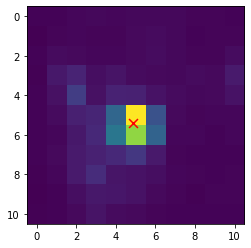

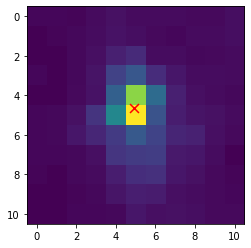

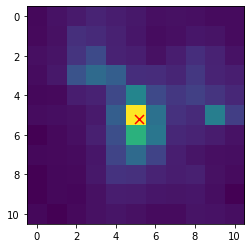

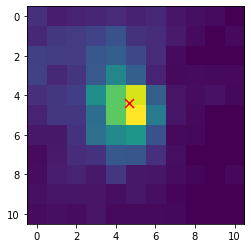

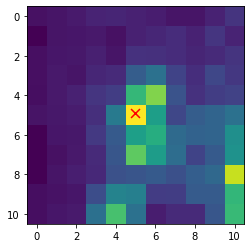

In [85]:
def runBraggNN(binned_image, x, y, scores, plot = True):
    '''Function that takes an entire binned detector image and approximate [x,y] coordinates
        of peaks within that image, and creates 11x11 patches and runs BragNN to determine precise peak location
        
    Arguments:
    binned_image - 2D array w/ detector image
    x, y - arrays of coordinates for peaks
    plot - whether to plot individual patches and fitted peak locations
    
    Returns:
    NN_fit - array of precise peak coordinates

    '''
    NN_fit = []
    scores_filtered = []
    for i in range(len(x)):
        x_c, y_c = x[i], y[i]
        try:
            #Define and normalize patch
            patch = binned_image[y_c-5:y_c+6 , x_c-5:x_c+6]
            patch = (patch - patch.min()) / (patch.max()-patch.min())

            #Check that max value within patch is roughly in the center
            x_max, y_max = np.unravel_index(patch.argmax(), patch.shape)

            if (x_max > 3) & (x_max < 7) & (y_max > 3) & (y_max < 7):
                #Run BragNN on patch
                input_tensor = torch.from_numpy(patch[np.newaxis, np.newaxis].astype('float32'))
                with torch.no_grad():
                    pred = model.forward(input_tensor).cpu().numpy()
                pred = pred * 11
                if plot:
                    plt.figure()
                    plt.imshow(patch)
                    plt.scatter(*pred[0], color='r', marker = 'x', s = 80)
                NN_fit.append(pred[0] + [x_c-5, y_c-5])
                scores_filtered.append(scores[i])
        except:
            print('Unable to generate/fit patch')
    return np.array(NN_fit), scores_filtered


NN_fit, scores_filtered = runBraggNN(binned_image, x, y,scores, plot = True)
print(NN_fit)

### Overlay  precise peak locations from BraggNN on input data

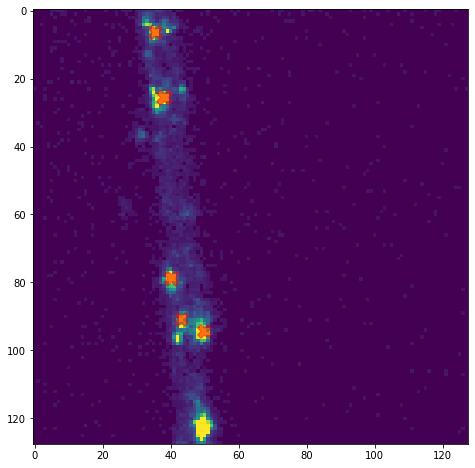

In [86]:
plt.figure(figsize = (8,8))
plt.imshow(binned_image, vmax = 100)
for i in range(len(scores_filtered)):
    plt.scatter(NN_fit[i][0], NN_fit[i][1], color = 'red', marker = 'X', s = np.log10(scores[i]) * 100, alpha = 0.5)
